In [ ]:
import numpy as np # linear algebra
import os
import torch, torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder, VisionDataset
import torchvision.transforms as transforms 
from itertools import chain
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
pip install torch-summary

In [ ]:
from torchsummary import summary

# Generator
I will create a generator whose architecture will be similar to the architecture of the U-Net convolutional network. This architecture uses convolutional layers to extract features from input data and a decoder to generate output data. In addition to this, U-Net utilizes a "skip connections" mechanism that adds information from lower-level layers to the output of the decoder, in order to improve the generation results.

![](http://miro.medium.com/max/828/1*J3t2b65ufsl1x6caf6GiBA.webp)

In [2]:
class Generator_CycleGAN(nn.Module): #Generator - U-net: conv3*3 ReLU(LeakyReLU) maxpool2*2 upconv2*2
    def __init__(self):
        super().__init__()
        self.conv1 = self.down_scale(3, 64) #      3*256*256 -->  64*128*128
        self.conv2 = self.down_scale(64, 128) #   64*128*128 --> 128* 64* 64
        self.conv3 = self.down_scale(128, 256) # 128* 64* 64 --> 256* 32* 32 
        self.conv4 = self.down_scale(256, 512) # 256* 32* 32 --> 512* 16* 16
        self.conv5 = self.down_scale(512, 512) # 512* 16* 16 --> 512*  8*  8
        self.conv6 = self.down_scale(512, 512) # 512*  8*  8 --> 512*  4*  4
        self.conv7 = self.down_scale(512, 512, kernel=1) # 512*  4*  4 --> 512*  2*  2
        self.conv8 = self.down_scale(512, 512, kernel=1) # 512*  2*  2 --> 512*  1*  1

        self.upconv1 = self.up_scale(512, 512, kernel=2) # 512*  1*  1 --> 512*  2*  2
        self.upconv2 = self.up_scale(1024, 512) #1024*  2*  2 --> 512*  4*  4   concatenate conv7
        self.upconv3 = self.up_scale(1024, 512) #1024*  4*  4 --> 512*  8*  8   concatenate conv6
        self.upconv4 = self.up_scale(1024, 512) #1024*  8*  8 --> 512* 16* 16   concatenate conv5
        self.upconv5 = self.up_scale(1024, 256) #1024* 16* 16 --> 256* 32* 32   concatenate conv4
        self.upconv6 = self.up_scale(512, 128)  # 512* 32* 32 --> 128* 64* 64   concatenate conv3
        self.upconv7 = self.up_scale(256, 64)   # 256* 64* 64 -->  64*128*128   concatenate conv2

        self.upconv8 = nn.ConvTranspose2d(128, 3, 2, stride=2, bias=False)    # 128*128*128 -->   3*256*256   concatenate conv1

    def down_scale(self, in_ch, out_ch, kernel=3, stride=1, batch_norm=True, dropout=False):
        block = [nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, bias=False, padding='same'),
                 nn.MaxPool2d(2)]
        if batch_norm:
            block.append(nn.BatchNorm2d(out_ch))
        block.append(nn.LeakyReLU())
        if dropout:
            block.append(nn.Dropout2d(0.5))
        result_block = nn.Sequential(*block)
        return result_block
  
    def up_scale(self, in_ch, out_ch, kernel=2, stride=2, batch_norm=True, dropout=False):
        block = [nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, bias=False)]
        if batch_norm:
            block.append(nn.BatchNorm2d(out_ch))
        block.append(nn.ReLU(inplace=True))
        if dropout:
            block.append(nn.Dropout2d(0.5))
        result_block = nn.Sequential(*block)
        return result_block

    def forward(self, x):
        down_1 = self.conv1(x)
        down_2 = self.conv2(down_1)
        down_3 = self.conv3(down_2)
        down_4 = self.conv4(down_3)
        down_5 = self.conv5(down_4)
        down_6 = self.conv6(down_5)
        down_7 = self.conv7(down_6)
        down_8 = self.conv8(down_7)

        up_1 = self.upconv1(down_8)
        up_1_cat = torch.cat((up_1, down_7), 1)
        up_2 = self.upconv2(up_1_cat)
        up_2_cat = torch.cat((up_2, down_6), 1)
        up_3 = self.upconv3(up_2_cat)
        up_3_cat = torch.cat((up_3, down_5), 1)
        up_4 = self.upconv4(up_3_cat)
        up_4_cat = torch.cat((up_4, down_4), 1)
        up_5 = self.upconv5(up_4_cat)
        up_5_cat = torch.cat((up_5, down_3), 1)
        up_6 = self.upconv6(up_5_cat)
        up_6_cat = torch.cat((up_6, down_2), 1)
        up_7 = self.upconv7(up_6_cat)
        up_7_cat = torch.cat((up_7, down_1), 1)
        up_8 = self.upconv8(up_7_cat)

        return nn.Tanh()(up_8)

Testing with packet torch-summary

In [ ]:
test_model = Generator_CycleGAN()
summary(test_model, (3, 256, 256))

# Discriminator

In [3]:
class Discriminator_CycleGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.down_scale(3, 64)      #   3*256*256 -->  64*128*128
        self.conv2 = self.down_scale(64, 128)    #  64*128*128 --> 128* 64* 64
        self.conv3 = self.down_scale(128, 256)   # 128* 64* 64 --> 256* 32* 32
        self.conv4 = self.down_scale(256, 512)   # 256* 32* 32 --> 512* 16* 16
        self.conv5 = self.down_scale(512, 512)   # 512* 16* 16 --> 512*  8*  8
        self.conv6 = self.down_scale(512, 512)   # 512*  8*  8 --> 512*  4*  4
        self.conv7 = self.down_scale(512, 1024)  # 512*  4*  4 -->1024*  2*  2
        self.conv8 = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, bias=False, padding=1)

    def down_scale(self, in_ch, out_ch, kernel=4, stride=2, batch_norm=True, dropout=False):
        block = [nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, bias=False, padding=1)]
        if batch_norm:
            block.append(nn.BatchNorm2d(out_ch))
        block.append(nn.LeakyReLU())
        if dropout:
            block.append(nn.Dropout2d(0.5))
        result_block = nn.Sequential(*block)
        return result_block

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = nn.Sigmoid()(x)
        return x.view(bs,-1)

In [ ]:
test_model = Discriminator_CycleGAN()
summary(test_model, (3, 256, 256))

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data processing

Function for data processing and forming DataLoader

In [5]:
def create_dataloader(path, img_size, batch_size):
    transform = transforms.Compose(
      [transforms.Resize(size=(img_size,img_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]
    )
    img_data = ImageFolder(path, transform)
    return DataLoader(img_data, batch_size, num_workers=2)

In [6]:
path_photo = '/kaggle/input/monet2ph/trainB'
path_pic = '/kaggle/input/monet2ph/trainA'
bs = 4
dataset_photo = create_dataloader(path_photo, 256, bs)
dataset_pic = create_dataloader(path_pic, 256, bs)

A batch formation function, that takes a dataset of images as input and forms a batch of images by randomly selecting images from the dataset.

In [7]:
def build_data_batch(dataset, bs):
    data_batch = []
    for _ in range(bs):
        data_batch.append(dataset.dataset[np.random.randint(0, len(dataset.dataset))][0])
    return torch.stack(data_batch)   

# Model, Loss, Optimizer
CycleGAN Model

In [9]:
gen_A = Generator_CycleGAN().to(device)
gen_B = Generator_CycleGAN().to(device)
disc_A = Discriminator_CycleGAN().to(device)
disc_B = Discriminator_CycleGAN().to(device)

model = {
    'generator_A': gen_A,
    'discriminator_A': disc_A,
    'generator_B': gen_B,
    'discriminator_B': disc_B
}

Losses and optimizers

In [9]:
losses_func = {
    'generator_A': nn.MSELoss(),
    'discriminator_A': nn.MSELoss(),
    'generator_B':nn.MSELoss(),
    'discriminator_B': nn.MSELoss(),
}

losses_func_2 = {
    'generator_A': nn.BCEWithLogitsLoss(),
    'discriminator_A': nn.BCEWithLogitsLoss(),
    'generator_B':nn.BCEWithLogitsLoss(),
    'discriminator_B': nn.BCEWithLogitsLoss(),
}

In [ ]:
optimizers = {
    'optimizer_gen': torch.optim.Adam(params=chain(model['generator_A'].parameters(),
                                            model['generator_B'].parameters()), 
                                      lr=0.0002, betas=(0.5, 0.999)),
    'optimizer_disc_A': torch.optim.Adam(params=model['discriminator_A'].parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999)),
    'optimizer_disc_B': torch.optim.Adam(params=model['discriminator_B'].parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999)),
}

# Model description and training function:

* Generator A - converts a photograph into a drawn image.
* Generator B - converts a drawn image into a photograph
* Discriminator A - distinguishes a photograph from a non-photograph
* Discriminator B - distinguishes a drawn image in a specific style from others
* X_real - photograph
* Y_real - drawn image
* y_fake_g - X_real --> Generator A --> image
* x_fake_g - Y_real --> Generator B --> photograph
* x_yfake - y_fake_g --> Generator B (cycle photo) --> photograph
* y_xfake - x_fake_g --> Generator A (cycle pic) --> drawn image
* x_xreal - X real --> Generator B (same photo) --> photograph
* y_yreal - Y_real --> Generator A (same pic) --> drawn image
* x_disc_a_gen - x_fake_g --> Discriminator A --> R:[0;1]
* y_disc_b_gen - y_fake_g --> Discriminator B --> R:[0;1]
* x_fake_d - Y_real --> Generator B --> photograph
* y_fake_d - X_real --> Generator A --> drawn image
* x_real_disc_a - X_real --> Discriminator A --> R:[0;1]
* x_fake_disc_a - x_fake_d --> Discriminator A --> R:[0;1]
* y_real_disc_b - Y_real --> Discriminator B --> R:[0;1]
* y_fake_disc_b - y_fake_d --> Discriminator B --> R:[0;1]

The training function will output examples of the results. The function also has the option to add noise to the discriminators.

In [10]:
def train_CycleGAN(dataloader_x, dataloader_y, model, criterion, optimizer, epochs=10, random_disc=0):

    torch.cuda.empty_cache()
    model['generator_A'].train()
    model['discriminator_A'].train()
    model['generator_B'].train()
    model['discriminator_B'].train()
  
    history = {
      'loss': {
          'generators_loss': [],
          'discriminators_loss': {
              'disc_A_loss': [],
              'disc_B_loss': []
              }
          },    
      }
  
    for epoch in range(epochs):
        i = 0
        print(f'epoch - {epoch+1}')
        loss_d_A = []
        loss_d_B = []
        loss_g = []
        for x_real, _ in dataloader_x:
            i += 1 
            x_real = x_real.to(device)
            y_real = build_data_batch(dataloader_y, dataloader_x.batch_size).to(device)
                
            #generators cycle
            y_fake_g = model['generator_A'](x_real) #real photo --> fake monet
            x_fake_g = model['generator_B'](y_real) #real monet --> fake photo
            x_yfake = model['generator_B'](y_fake_g) #real photo --> fake monet --> cycle photo
            y_xfake = model['generator_A'](x_fake_g) #real monet --> fake photo --> cycle monet
            x_xreal = model['generator_B'](x_real) #real photo --> same photo
            y_yreal = model['generator_A'](y_real) #real monet --> same monet
            
            x_disc_a_gen = model['discriminator_A'](x_fake_g)
            y_disc_b_gen = model['discriminator_B'](y_fake_g)
            optimizer['optimizer_gen'].zero_grad()
            
            generator_A_loss = criterion['generator_A'](torch.ones_like(y_disc_b_gen), y_disc_b_gen)
            generator_B_loss = criterion['generator_B'](torch.ones_like(x_disc_a_gen), x_disc_a_gen)
            generator_A_B_cycle_loss = torch.mean(torch.abs(y_xfake - y_real)) + \
            torch.mean(torch.abs(x_yfake - x_real))
            generator_A_loss_yy_real = torch.mean(torch.abs(y_yreal - y_real))
            generator_B_loss_xx_real = torch.mean(torch.abs(x_xreal - x_real))
      
            total_generator_loss = generator_A_loss + 10*generator_A_B_cycle_loss + \
            generator_B_loss + generator_A_loss_yy_real + generator_B_loss_xx_real
    
            total_generator_loss.backward()
            optimizer['optimizer_gen'].step()
            
            #discriminators cycle
            y_fake_d = model['generator_A'](x_real)
            x_fake_d = model['generator_B'](y_real)
            x_real_disc_a = model['discriminator_A'](x_real)
            x_fake_disc_a = model['discriminator_A'](x_fake_d)
            y_real_disc_b = model['discriminator_B'](y_real)
            y_fake_disc_b = model['discriminator_B'](y_fake_d)
            
            true_labels_d_a = (torch.ones(x_real_disc_a.shape[0],1) - \
                               torch.rand(x_real_disc_a.shape[0],1) * random_disc).to(device)
            true_labels_d_b = (torch.ones(y_real_disc_b.shape[0],1) - \
                               torch.rand(y_real_disc_b.shape[0],1) * random_disc).to(device)
            fake_labels_d_a = (torch.zeros(x_fake_disc_a.shape[0],1) + \
                               torch.rand(x_fake_disc_a.shape[0],1) * random_disc).to(device)
            fake_labels_d_b = (torch.zeros(y_fake_disc_b.shape[0],1) + \
                               torch.rand(y_fake_disc_b.shape[0],1) * random_disc).to(device)
            
            optimizer['optimizer_disc_A'].zero_grad()
            optimizer['optimizer_disc_B'].zero_grad()
            
            discriminator_A_loss_x = 0.5 * (criterion['discriminator_A'](true_labels_d_a, x_real_disc_a) + \
                                      criterion['discriminator_A'](fake_labels_d_a, x_fake_disc_a)) 
            discriminator_B_loss_y = 0.5 * (criterion['discriminator_B'](true_labels_d_b, y_real_disc_b) + \
                                      criterion['discriminator_B'](fake_labels_d_b, y_fake_disc_b))
            discriminator_A_loss_x.backward()
            discriminator_B_loss_y.backward()
            optimizer['optimizer_disc_A'].step() 
            optimizer['optimizer_disc_B'].step()
      
            loss_d_A.append(discriminator_A_loss_x)
            loss_d_B.append(discriminator_B_loss_y)
            loss_g.append(total_generator_loss)

            if i % 100 == 0:
                print(f'Bs: {i} --- Loss discriminator A: {sum(loss_d_A)/len(loss_d_A)} --- Loss discriminator B: {sum(loss_d_B)/len(loss_d_B)}')
                print(f'Loss generator: {sum(loss_g)/len(loss_g)}')
                with torch.no_grad():
                    rand_number = np.random.randint(0, bs)
                    generated_photo_pic = model['generator_A'](x_real)
                    generated_pic_photo = model['generator_B'](y_real)
                    print('Photo2Pic -- Generator A')
                    plt.subplot(1, 2, 1).set_title('Result - Picture')
                    plt.imshow(np.rollaxis((generated_photo_pic[rand_number]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.subplot(1, 2, 2).set_title('Input - Photo')
                    plt.imshow(np.rollaxis((x_real[rand_number]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.show()
                    print('Pic2Photo -- Generator B')
                    plt.subplot(1, 2, 1).set_title('Result - Photo')
                    plt.imshow(np.rollaxis((generated_pic_photo[rand_number]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.subplot(1, 2, 2).set_title('Input - Picture')
                    plt.imshow(np.rollaxis((y_real[rand_number]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.show()
                    
#             if i == 20:  #for testing
#                 break
        history['loss']['discriminators_loss']['disc_A_loss'].append(torch.stack(loss_d_A).detach().cpu().numpy())
        history['loss']['discriminators_loss']['disc_B_loss'].append(torch.stack(loss_d_B).detach().cpu().numpy())
        history['loss']['generators_loss'].append(torch.stack(loss_g).detach().cpu().numpy())
  
    return history

# Training and results

In [ ]:
hist = train_CycleGAN(dataset_photo, dataset_pic, model, losses_func, optimizers, epochs=1, random_disc=0.08)

In [12]:
hist['loss']

{'generators_loss': [array([16.11     , 14.641762 , 14.418976 , ...,  3.3816054,  4.021441 ,
          4.8827457], dtype=float32)],
 'discriminators_loss': {'disc_A_loss': [array([0.33102316, 0.3169719 , 0.35544148, ..., 0.22886054, 0.15780729,
          0.0845829 ], dtype=float32)],
  'disc_B_loss': [array([0.35409418, 0.31112838, 0.33645448, ..., 0.19043931, 0.16913463,
          0.19489676], dtype=float32)]}}

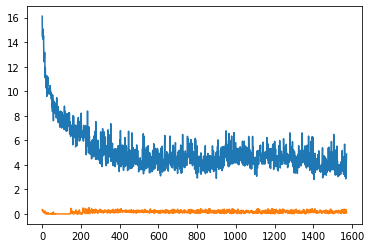

In [16]:
plt.plot(hist['loss']['generators_loss'][0])

Generate 10 examples and show

In [21]:
path_photo_test = '/kaggle/input/monet2ph/testB'
bs = 4
dataset_photo_test = create_dataloader(path_photo_test, 256, bs)

In [17]:
def show_picture(data, model):
    random_idx = np.round(np.random.rand(1, 10)*len(data.dataset))
    random_idx = np.int32(random_idx)
    res = []   
    for idx in random_idx[0]:
        pic = data.dataset[idx][0]
        res.append(pic)
    res = torch.stack(res).to(device)
    result_images = model['generator_A'](res)
    box_pred = plt.figure(figsize=(20,40))
    for i in range(9):
        box_pred.add_subplot(5, 3, i+1)
        plt.imshow(np.rollaxis((result_images[i]*0.5+0.5).detach().cpu().numpy(), 0, 3))
        plt.axis('off')

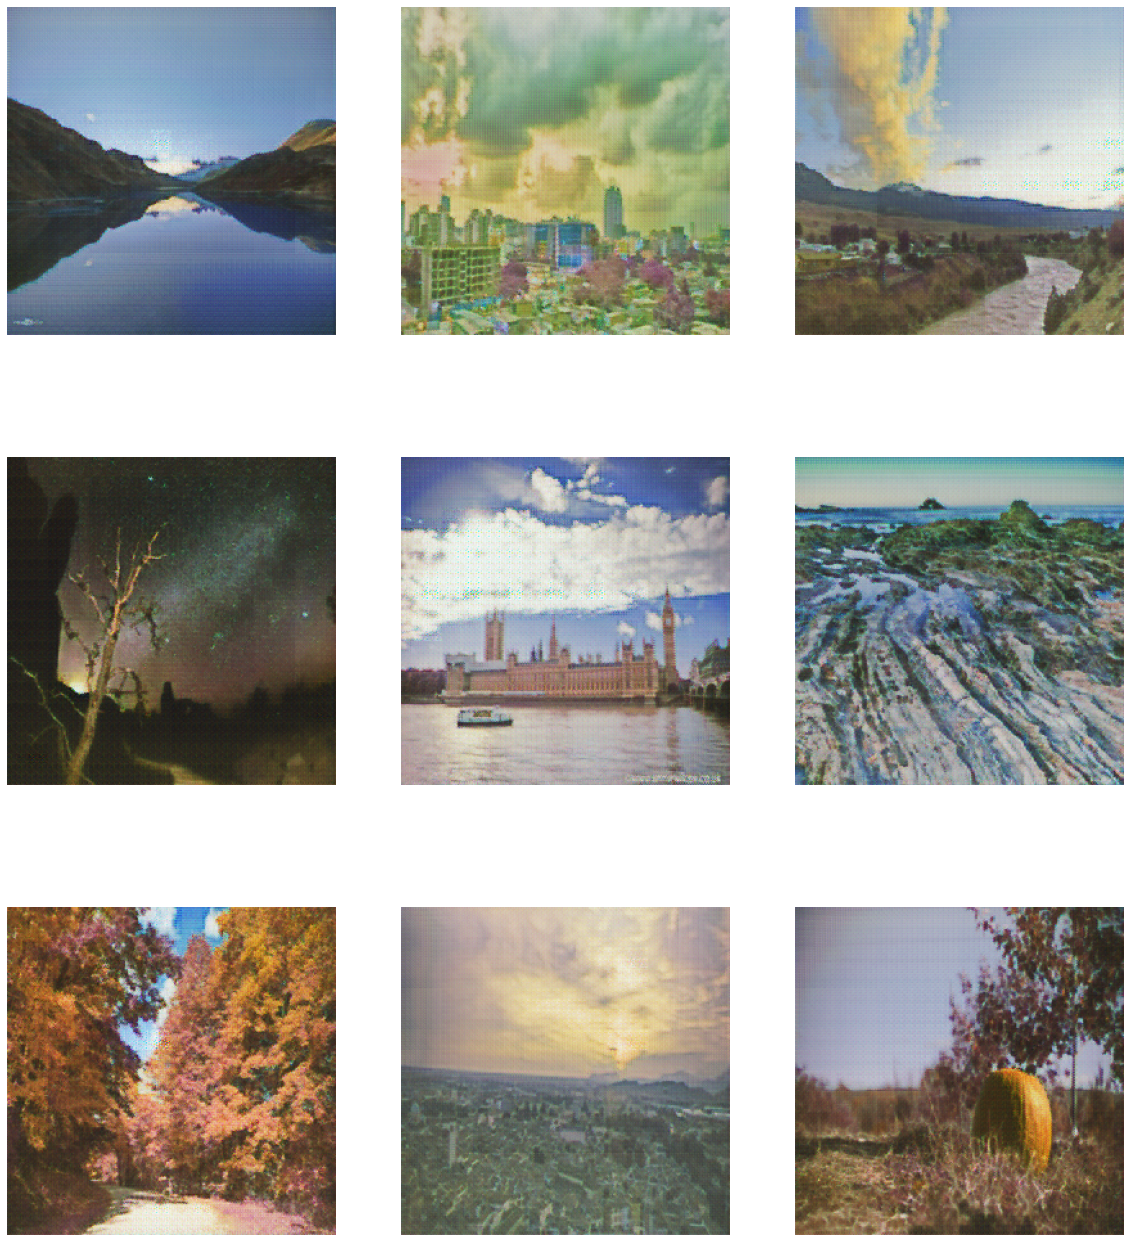

In [222]:
show_picture(dataset_photo_test)

The training function will output examples of results while also providing the option to add noise to the discriminators. Conclusively, the photographs change their stylistic features, particularly noticeable on natural landscapes. Occasionally, artifacts may appear.

Try on Disney pictures

In [11]:
path_disney = '/kaggle/input/disney-pic'
bs = 4
dataset_disney = create_dataloader(path_disney, 256, bs)

In [13]:
gen_A_2 = Generator_CycleGAN().to(device)
gen_B_2 = Generator_CycleGAN().to(device)
disc_A_2 = Discriminator_CycleGAN().to(device)
disc_B_2 = Discriminator_CycleGAN().to(device)

model_wb = {
    'generator_A': gen_A_2,
    'discriminator_A': disc_A_2,
    'generator_B': gen_B_2,
    'discriminator_B': disc_B_2
}
optimizers_wb = {
    'optimizer_gen': torch.optim.Adam(params=chain(model_wb['generator_A'].parameters(),
                                            model_wb['generator_B'].parameters()), 
                                      lr=0.0002, betas=(0.5, 0.999)),
    'optimizer_disc_A': torch.optim.Adam(params=model_wb['discriminator_A'].parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999)),
    'optimizer_disc_B': torch.optim.Adam(params=model_wb['discriminator_B'].parameters(), 
                                         lr=0.0002, betas=(0.5, 0.999)),
}

In [ ]:
hist2 = train_CycleGAN(dataset_photo, dataset_disney, model_wb, losses_func, optimizers_wb, epochs=3, random_disc=0.04)

The output shows that the photographs become more contrasty, with some colors changing to others. Some of the photographs do resemble the landscapes of Disney cartoons, while others have more saturated colors. However, the majority of the photographs do not look like scenes from animation films. This is likely due to the fact that the dataset of cartoon images is not homogeneous and includes characters and objects in close-up shots in addition to landscapes. Some examples of the resulting images are shown below.

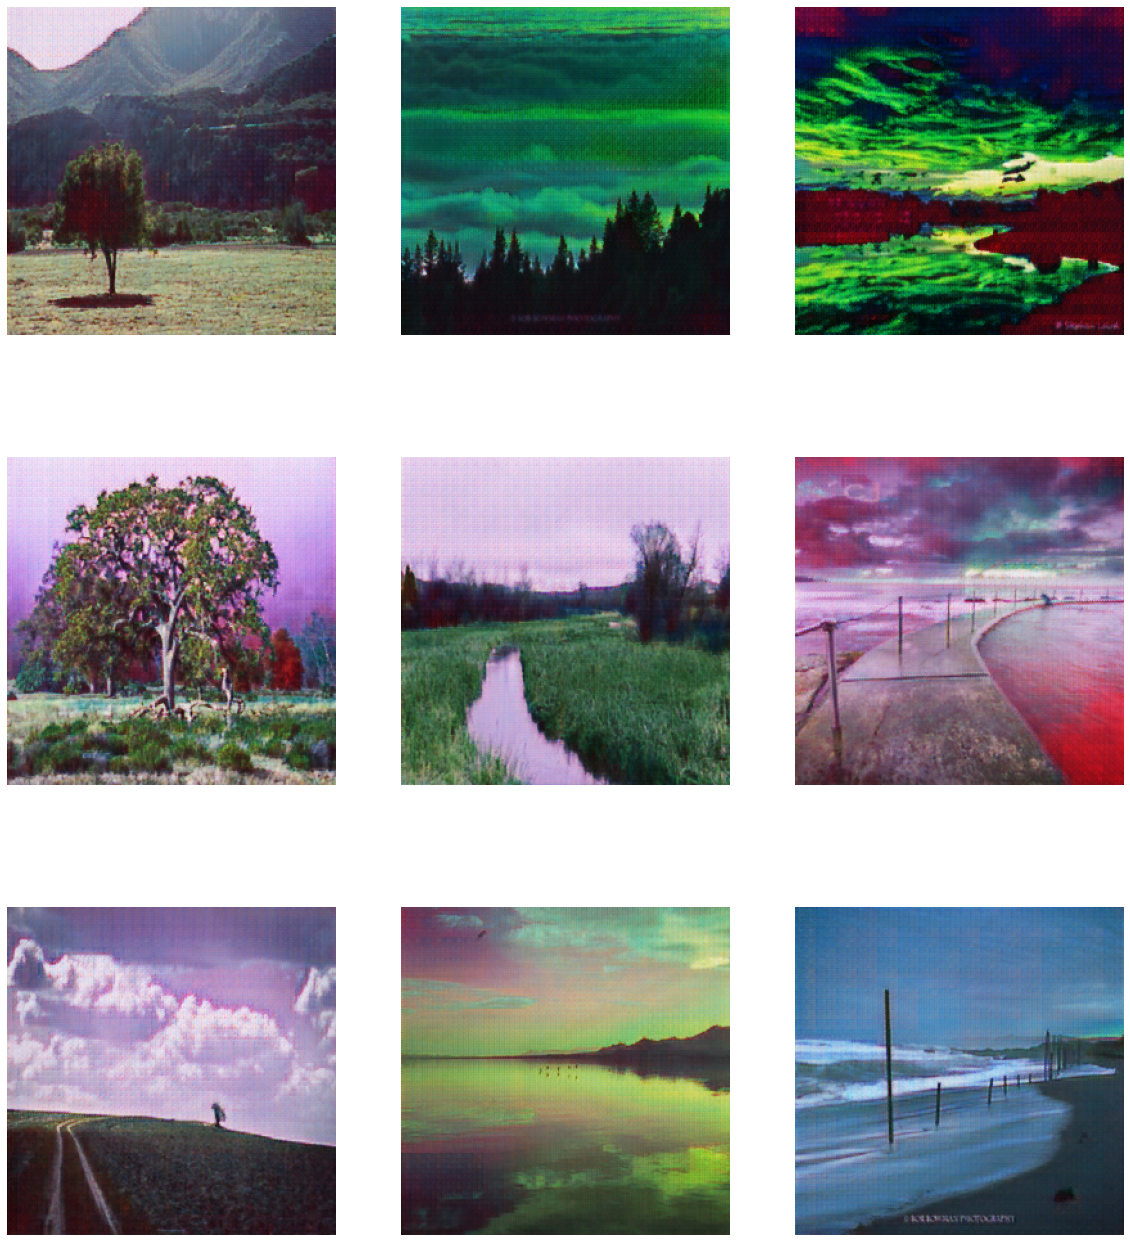

In [22]:
show_picture(dataset_photo_test, model_wb)

Datasets:
* https://www.kaggle.com/datasets/balraj98/monet2photo
* https://www.kaggle.com/datasets/alexkonse/disney-pic

Examples (from this notebook):
* https://drive.google.com/file/d/1TlDHMKvRsKTvnH62ZF98zPOYBBKModfR/view?usp=sharing
* https://drive.google.com/file/d/18QOuF7OGJekFhUf0eu80H9ol6CCwzkWE/view?usp=sharing